In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import random

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from torch import optim 
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

torch.__version__ 

'1.11.0+cu113'

In [2]:
!nvidia-smi

Mon May 16 10:47:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Prepare Data

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import requests
from tqdm.notebook import tqdm
from google.colab import drive
import os

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
df = pd.read_csv('https://raw.githubusercontent.com/saenyakorn/cars-classification/main/data/car.csv')

In [46]:
df.head()

,kind,name,image_url,start_year,end_year,doors
0,SUV cars,Audi Q3 1.4 TFSI,https://www.cars-data.com/pictures/thumbs/350p...,2013,2015,5
1,SUV cars,Audi Q5 2.0 TFSI 180hp quattro,https://www.cars-data.com/pictures/thumbs/350p...,2009,2012,5
2,SUV cars,Audi Q7 3.6 FSI quattro,https://www.cars-data.com/pictures/thumbs/350p...,2008,2008,5
3,SUV cars,Audi Q7 3.0 TFSI 272hp quattro,https://www.cars-data.com/pictures/thumbs/350p...,2010,2015,5
4,SUV cars,BMW X1 sDrive18i,https://www.cars-data.com/pictures/thumbs/350p...,2010,2011,5


In [33]:
df.drop(['name', 'start_year', 'end_year', 'doors'], axis=1, inplace=True)

In [34]:
df['kind'] = pd.factorize(df['kind'])[0]

In [35]:
df.reset_index(inplace=True)

In [36]:
y = df.pop('kind')
x = df

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,train_size=0.8, stratify=y, random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.25,train_size =0.75, stratify=y_train, random_state=123)

In [38]:
x_train

,index,image_url
729,729,https://www.cars-data.com/pictures/thumbs/350p...
1887,1887,https://www.cars-data.com/pictures/thumbs/350p...
734,734,https://www.cars-data.com/pictures/thumbs/350p...
460,460,https://www.cars-data.com/pictures/thumbs/350p...
2431,2431,https://www.cars-data.com/pictures/thumbs/350p...
...,...,...
1879,1879,https://www.cars-data.com/pictures/thumbs/350p...
368,368,https://www.cars-data.com/pictures/thumbs/350p...
3482,3482,https://www.cars-data.com/pictures/thumbs/350p...
3175,3175,https://www.cars-data.com/pictures/thumbs/350p...


In [ ]:
def download_pic(df, df2, folder):
    drops = []
    root = f'gdrive/MyDrive/Data/{folder}'
    os.mkdir(root)
    for idx,row in tqdm(df.iterrows(), total=df.shape[0]):
        r = requests.get(row['image_url'])
        if r.headers['Content-type'] == 'image/jpeg':
            with open(f"{root}/{row['index']}.jpg", 'wb') as f:
                f.write(r.content)
        else:
            drops.append(idx)
    return (df.drop(drops), df2.drop(drops))

In [ ]:
x_train, y_train = download_pic(x_train, y_train, 'train')
x_val, y_val = download_pic(x_val, y_val, 'val')
x_test, y_test = download_pic(x_test, y_test, 'test')

In [ ]:
def create_labels(x, y, folder):
    labels = pd.concat([x['index'],y],axis=1)
    labels.to_csv(f"gdrive/MyDrive/Data/{folder}/labels.csv", index=False)

In [ ]:
create_labels(x_train,y_train,'train')
create_labels(x_val,y_val,'val')
create_labels(x_test,y_test,'test')

# Data prep

In [32]:
class CarDataset(Dataset): 
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.label_df = pd.read_csv(f'{self.root_dir}/labels.csv')
  
  def __len__(self):
    return len(self.label_df)
  
  def __getitem__(self, idx): 
    data = self.label_df.iloc[idx]
    img = Image.open(f"{self.root_dir}/{data['index']}.jpg").convert('RGB')
    if self.transform is not None: 
        transformed_img = self.transform(img) 
    else: 
        transformed_img = img 
    kind = data['kind']
    return transformed_img, kind

In [33]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [34]:
unnormalizer = UnNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [35]:
img_size = 224
batch_size = 15

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

train_dataset = CarDataset('gdrive/MyDrive/Data/train', train_transform)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
val_dataset = CarDataset('gdrive/MyDrive/Data/val', val_transform)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, pin_memory=True)
test_dataset = CarDataset('gdrive/MyDrive/Data/test', test_transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, pin_memory=True)

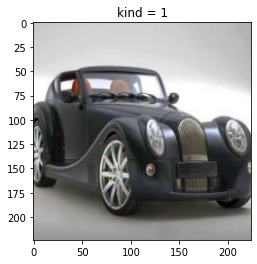

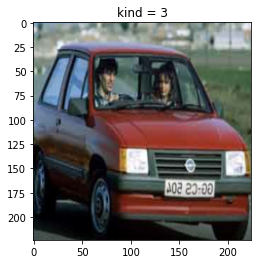

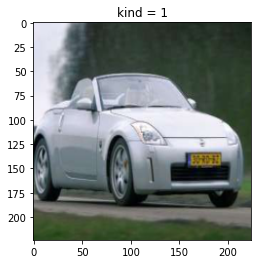

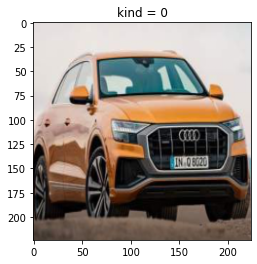

In [36]:
for idx in range(4): 
  img, kind = train_dataset[idx] 
  img = unnormalizer(img) 
  plt.title(f'kind = {kind}')  
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.show()

# Model

In [37]:
import torchvision.models as models

class CNNNetwork(nn.Module):
    def __init__(self): 
        super().__init__()
        self.vgg = models.vgg19(pretrained=True)
        self.ff = nn.Linear(1000, 5)
        self.softmax = nn.Softmax(dim=1)
    

    def forward(self, x):
        y = self.vgg(x)
        y = self.ff(y)
        y = self.softmax(y)
        return y

In [38]:
cnn_model = CNNNetwork()

In [39]:
summary(cnn_model, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
CNNNetwork                               --                        --
├─VGG: 1-1                               [1, 1000]                 --
│    └─Sequential: 2-1                   [1, 512, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         1,792
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                  [1, 64, 224, 224]         36,928
│    │    └─ReLU: 3-4                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-6                  [1, 128, 112, 112]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-8                  [1, 128, 112, 112]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 56, 56]          --

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=1e-8)

# Train

In [41]:
num_epochs = 40
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model.to(device)

train_losses = []
val_losses = []
min_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    cnn_model.train()
    total_train_loss = 0
    for img, label in train_dataloader:
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(img)
        train_loss = criterion(outputs, label)
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()
    current_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(current_train_loss)

    total_val_loss = 0
    cnn_model.eval()
    with torch.no_grad():
        for val_img, val_label in val_dataloader:
            val_img = val_img.to(device)
            val_label = val_label.to(device)
            val_outputs = cnn_model(val_img)
            val_loss = criterion(val_outputs, val_label)
            total_val_loss += val_loss.item()
    current_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(current_val_loss)
    if current_val_loss < min_val_loss: 
        min_val_loss = current_val_loss 
        torch.save(cnn_model.state_dict(), 'best_weights.pth')
    print(f'Epoch {epoch+1} - Train loss = {current_train_loss:.4f} - Val loss = {current_val_loss:.4f} - best min_val_loss = {min_val_loss:.4f} - lr = {optimizer.param_groups[0]["lr"]:.8f}') 
    scheduler.step(current_val_loss)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Train loss = 1.4091 - Val loss = 1.2423 - best min_val_loss = 1.2423 - lr = 0.00002000
Epoch 2 - Train loss = 1.2609 - Val loss = 1.2638 - best min_val_loss = 1.2423 - lr = 0.00002000
Epoch 3 - Train loss = 1.1902 - Val loss = 1.2498 - best min_val_loss = 1.2423 - lr = 0.00002000
Epoch 4 - Train loss = 1.1715 - Val loss = 1.1962 - best min_val_loss = 1.1962 - lr = 0.00002000
Epoch 5 - Train loss = 1.0929 - Val loss = 1.2542 - best min_val_loss = 1.1962 - lr = 0.00002000
Epoch 6 - Train loss = 1.0805 - Val loss = 1.1899 - best min_val_loss = 1.1899 - lr = 0.00002000
Epoch 7 - Train loss = 1.0835 - Val loss = 1.1455 - best min_val_loss = 1.1455 - lr = 0.00002000
Epoch 8 - Train loss = 1.0360 - Val loss = 1.2003 - best min_val_loss = 1.1455 - lr = 0.00002000
Epoch 9 - Train loss = 1.0328 - Val loss = 1.2070 - best min_val_loss = 1.1455 - lr = 0.00002000
Epoch 10 - Train loss = 1.0046 - Val loss = 1.1124 - best min_val_loss = 1.1124 - lr = 0.00002000
Epoch 11 - Train loss = 0.998

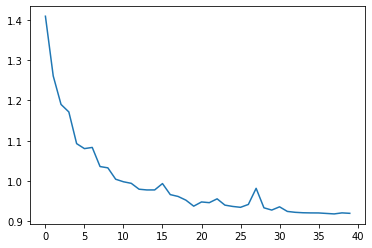

In [42]:
plt.plot(train_losses)
plt.show()

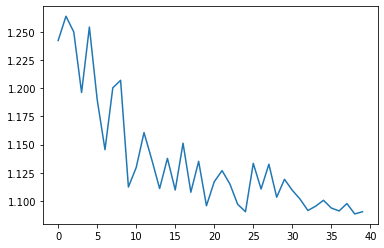

In [43]:
plt.plot(val_losses)
plt.show()

# Test

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model.to(device)

CNNNetwork(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [45]:
cnn_model.load_state_dict(torch.load('best_weights.pth'))

<All keys matched successfully>

tensor([[5.9243e-07, 6.6571e-04, 9.9933e-01, 4.7761e-08, 9.5883e-07]])


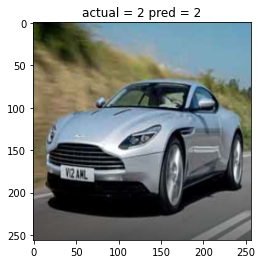

tensor([[1.0000e+00, 2.4054e-21, 1.4892e-26, 2.2791e-24, 2.6972e-25]])


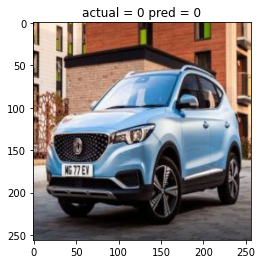

tensor([[9.1993e-01, 9.3023e-06, 2.0662e-08, 8.0057e-02, 4.9572e-07]])


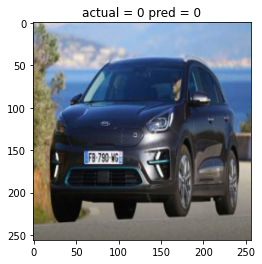

tensor([[1.4827e-08, 1.9312e-10, 1.9159e-08, 5.3825e-04, 9.9946e-01]])


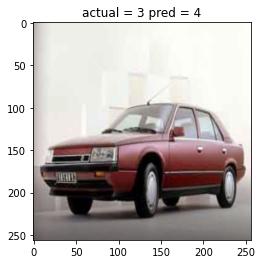

tensor([[1.0000e+00, 1.5876e-07, 1.0119e-10, 8.1149e-08, 6.2006e-09]])


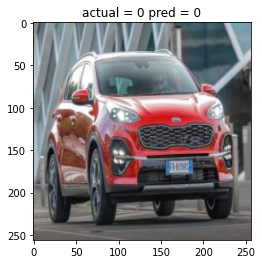

In [46]:
cnn_model.eval()
with torch.no_grad():
    for idx in range(5): 
        img, kind = test_dataset[idx] 
        outputs = cnn_model(img.unsqueeze(0).to(device)).detach().cpu()
        print(outputs)
        pred = torch.argmax(outputs)
        img = unnormalizer(img)
        plt.title(f'actual = {kind} pred = {pred}')  
        plt.imshow(np.transpose(img, (1,2,0)))
        plt.show()

In [47]:
cnn_model.eval()
labels = np.array([])
preds = np.array([])
with torch.no_grad():
    for img, label in test_dataloader:
        outputs = cnn_model(img.to(device)).detach().cpu()
        pred = torch.argmax(outputs, dim=1)
        labels = np.concatenate((labels, label.numpy()))
        preds = np.concatenate((preds, pred.numpy()))

In [48]:
cm = confusion_matrix(labels, preds)
cm

array([[108,   0,   0,   3,   1],
       [  1,  47,   3,   6,   0],
       [  1,  10,  37,  10,  11],
       [  7,   4,   7, 173,  31],
       [  5,   2,   2,  31,  95]])

In [49]:
cm_df = pd.DataFrame(cm, columns=['SUV cars', 'convertible car', 'coupe cars', 'hatchback cars','sedan cars'])
cm_df = pd.concat((cm_df, pd.DataFrame(['SUV cars', 'convertible car', 'coupe cars', 'hatchback cars','sedan cars'],columns=['type'])), axis=1).set_index('type')
cm_df

,SUV cars,convertible car,coupe cars,hatchback cars,sedan cars
type,,,,,
SUV cars,108,0,0,3,1
convertible car,1,47,3,6,0
coupe cars,1,10,37,10,11
hatchback cars,7,4,7,173,31
sedan cars,5,2,2,31,95


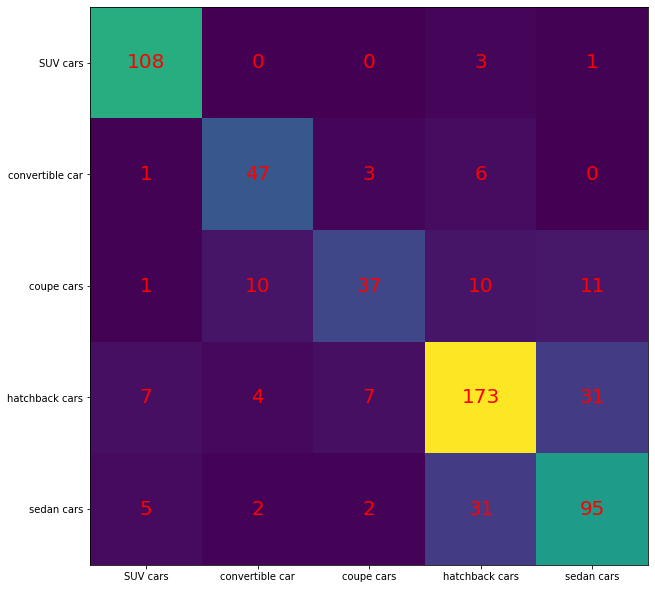

In [50]:
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(cm_df)
ax.set_xticks(np.arange(len(cm_df)))
ax.set_xticklabels(cm_df.index)
ax.set_yticks(np.arange(len(cm_df)))
ax.set_yticklabels(cm_df.index)
plt.setp(ax.get_xlabel(), rotation=45, ha='right')
for i in range(len(cm_df)):
    for j in range(len(cm_df)):
        text = ax.text(j, i, cm_df.iloc[i, j], ha='center', va='center', color='r', size=20)

In [51]:
print(classification_report(labels, preds, target_names=['SUV cars', 'convertible car', 'coupe cars', 'hatchback cars','sedan cars'], digits=4))

                 precision    recall  f1-score   support

       SUV cars     0.8852    0.9643    0.9231       112
convertible car     0.7460    0.8246    0.7833        57
     coupe cars     0.7551    0.5362    0.6271        69
 hatchback cars     0.7758    0.7793    0.7775       222
     sedan cars     0.6884    0.7037    0.6960       135

       accuracy                         0.7731       595
      macro avg     0.7701    0.7616    0.7614       595
   weighted avg     0.7713    0.7731    0.7695       595

